# Notebook for Parts of Speech Analysis

Using spaCy for parts of speech analysis, we want to create relative frequency tables for the parts of speech by year.

Currently processes the "Fakespeak-ENG modified.xlsx" file (I've renamed my copy to "Fakespeak_ENG_modified.xlsx" to create a more consistent path), but will eventually be run on data from MisInfoText as well.

From the original data file, we use the following columns: ID, combinedLabel, originalTextType, originalBodyText, originalDateYear

We are processing text from the "originalBodyText" column.

In [4]:
import os
from itertools import chain
import spacy
from spacy.tokens.doc import Doc
from spacy.tokens.token import Token
import pandas as pd
from dataset_config import BASE_FAKESPEAK_CONFIG, BASE_MISINFOTEXT_CONFIG

In [2]:
!pip install xlsxwriter # for writing to multiple excel sheets


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Loading articles into dataframes, separated by year

In [5]:
fakespeak_config = BASE_FAKESPEAK_CONFIG | {
    "output_path": "./data/Fakespeak-ENG/Analysis_output/Fakespeak_POS_frequency.xlsx",
}

misinfotext_config = BASE_MISINFOTEXT_CONFIG | {
    "output_path": "./data/MisInfoText/Analysis_output/MisInfoText_POS_frequency.xlsx",
}

In [6]:
using_dataset = fakespeak_config

In [7]:
dataset_df = pd.read_excel(
    using_dataset["input_path"], 
    sheet_name=using_dataset["sheet_name"], 
    usecols=using_dataset["usecols"]
)

In [ ]:
# Set this to True if you want to filter by only
# "News and blog" or "Social media" article types.
# It will save to a separate subdirectory without overwriting
# the existing files.
only_use_news_blog_and_social_media = True

if only_use_news_blog_and_social_media:
    dataset_df = dataset_df[(dataset_df["originalTextType"] == "News and blog") | (dataset_df["originalTextType"] == "Social media")]
    
    output_path = using_dataset.output_path
    output_path_split = output_path.split("/")
    output_path_split.insert(len(output_path_split) - 1, "news_blog_and_social_media")
    using_dataset.output_path = "/".join(output_path_split)

    os.makedirs("/".join(output_path_split[:-1]), exist_ok=True)

In [8]:
dataset_df.head()

,ID,combinedLabel,originalTextType,originalBodyText,originalDateYear
0,Politifact_FALSE_Social media_687276,False,Social media,Mexico is paying for the Wall through the new ...,2019
1,Politifact_FALSE_Social media_25111,False,Social media,"Chuck Schumer: ""why should American citizens b...",2019
2,Politifact_FALSE_Social media_735424,False,Social media,Billions of dollars are sent to the State of C...,2019
3,Politifact_FALSE_Social media_594307,False,Social media,If 50 Billion $$ were set aside to go towards ...,2019
4,Politifact_FALSE_Social media_839325,False,Social media,Huge@#CD 9 news. \n@ncsbe\n sent letter to eve...,2019


## Tagging parts of speech using spaCy

Using the small English web model, we tag the parts of speech in the body text by making article's body text a string, analyzing the string using spaCy, and then appending each token to a list manually.

We end up with a dataframe of many rows since each tag/tagged token takes up one row - this is fine since we are looking at overall counts in a year and we don't need to preserve the delineation between articles.

In [9]:
nlp = spacy.load("en_core_web_sm")

c:\Users\Adam\AppData\Local\Python\pythoncore-3.11-64\Lib\site-packages\coreferee\manager.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [10]:
def get_tokens(doc: Doc):
    return [token for token in doc]

def get_pos(token: Token):
    return token.pos_

In [12]:
dataset_df["doc"] = list(nlp.pipe(dataset_df[using_dataset["text_col"]]))

In [16]:
dataset_df["token"] = dataset_df["doc"].apply(get_tokens)
pos_df = dataset_df.explode("token")
pos_df["POS"] = pos_df["token"].apply(get_pos)
pos_df

,ID,combinedLabel,originalTextType,originalBodyText,originalDateYear,doc,token,POS
0,Politifact_FALSE_Social media_687276,False,Social media,Mexico is paying for the Wall through the new ...,2019,"(Mexico, is, paying, for, the, Wall, through, ...",Mexico,PROPN
0,Politifact_FALSE_Social media_687276,False,Social media,Mexico is paying for the Wall through the new ...,2019,"(Mexico, is, paying, for, the, Wall, through, ...",is,AUX
0,Politifact_FALSE_Social media_687276,False,Social media,Mexico is paying for the Wall through the new ...,2019,"(Mexico, is, paying, for, the, Wall, through, ...",paying,VERB
0,Politifact_FALSE_Social media_687276,False,Social media,Mexico is paying for the Wall through the new ...,2019,"(Mexico, is, paying, for, the, Wall, through, ...",for,ADP
0,Politifact_FALSE_Social media_687276,False,Social media,Mexico is paying for the Wall through the new ...,2019,"(Mexico, is, paying, for, the, Wall, through, ...",the,DET
...,...,...,...,...,...,...,...,...
2960,Politifact_Pants on Fire_Social media_621529,Pants on Fire,Social media,ANYBODY ELSE FIND IT FUNNY THAT ISRAEL WAS ATT...,2023,"(ANYBODY, ELSE, FIND, IT, FUNNY, THAT, ISRAEL,...",ON,PROPN
2960,Politifact_Pants on Fire_Social media_621529,Pants on Fire,Social media,ANYBODY ELSE FIND IT FUNNY THAT ISRAEL WAS ATT...,2023,"(ANYBODY, ELSE, FIND, IT, FUNNY, THAT, ISRAEL,...",A,PRON
2960,Politifact_Pants on Fire_Social media_621529,Pants on Fire,Social media,ANYBODY ELSE FIND IT FUNNY THAT ISRAEL WAS ATT...,2023,"(ANYBODY, ELSE, FIND, IT, FUNNY, THAT, ISRAEL,...",MONTHLY,PROPN
2960,Politifact_Pants on Fire_Social media_621529,Pants on Fire,Social media,ANYBODY ELSE FIND IT FUNNY THAT ISRAEL WAS ATT...,2023,"(ANYBODY, ELSE, FIND, IT, FUNNY, THAT, ISRAEL,...",BASIS,PROPN


## Create relative frequency tables of parts of speech by year

In [18]:
grouped_by_year = pos_df.groupby(by=using_dataset["year_col"])

### Summary tables for easy glancing

In [19]:
summary_counts_df = grouped_by_year["POS"].value_counts().unstack(fill_value=0)
summary_counts_df

POS,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SPACE,SYM,VERB,X
originalDateYear,,,,,,,,,,,,,,,,,,
2019,2175,3551,1217,1915,1085,2708,52,6641,744,1055,2502,3557,4099,670,1020,133,4168,60
2020,7905,12701,4676,7367,3505,10212,148,22970,3065,3555,8740,15448,15684,2669,4237,658,14936,259
2021,9021,14242,5087,7557,4082,11522,126,26692,3497,3982,8797,14316,17555,2766,4261,453,16357,218
2022,5619,8722,3281,4374,2392,6841,75,16320,2473,2256,5234,8624,10639,1683,2585,518,9725,212
2023,7231,11285,3690,5565,3139,9163,78,21830,2109,2978,6552,12022,13904,2090,3906,576,13075,225
2024,1525,2480,920,1329,660,2065,37,4542,456,699,1774,3023,3272,466,771,200,3088,91


<Axes: xlabel='POS'>

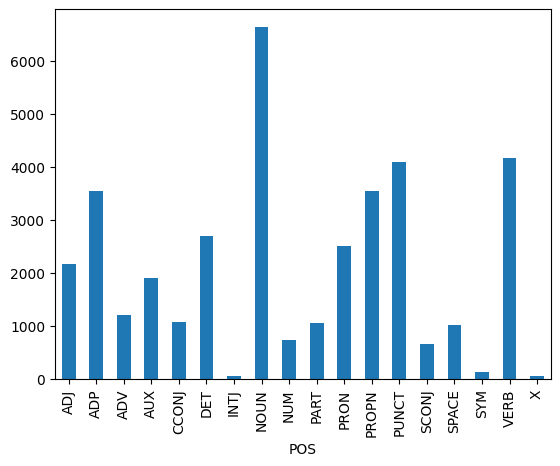

In [20]:
# Plot the first year's POS counts for visualization
summary_counts_df.iloc[0].plot(kind="bar")

In [21]:
summary_proportions_df = grouped_by_year["POS"].value_counts(normalize=True).unstack(fill_value=0)
summary_proportions_df

POS,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SPACE,SYM,VERB,X
originalDateYear,,,,,,,,,,,,,,,,,,
2019,0.058230,0.095069,0.032582,0.051269,0.029048,0.072499,0.001392,0.177795,0.019919,0.028245,0.066984,0.095229,0.109740,0.017937,0.027308,0.003561,0.111587,0.001606
2020,0.056979,0.091549,0.033705,0.053101,0.025264,0.073608,0.001067,0.165567,0.022092,0.025624,0.062998,0.111349,0.113050,0.019238,0.030540,0.004743,0.107658,0.001867
2021,0.059928,0.094612,0.033794,0.050202,0.027117,0.076542,0.000837,0.177319,0.023231,0.026453,0.058440,0.095103,0.116620,0.018375,0.028306,0.003009,0.108662,0.001448
2022,0.061361,0.095246,0.035829,0.047765,0.026121,0.074705,0.000819,0.178218,0.027006,0.024636,0.057157,0.094176,0.116181,0.018379,0.028229,0.005657,0.106199,0.002315
2023,0.060552,0.094500,0.030900,0.046601,0.026286,0.076730,0.000653,0.182803,0.017661,0.024938,0.054866,0.100672,0.116431,0.017502,0.032709,0.004823,0.109489,0.001884
2024,0.055661,0.090518,0.033579,0.048507,0.024089,0.075370,0.001350,0.165779,0.016644,0.025513,0.064749,0.110337,0.119425,0.017009,0.028141,0.007300,0.112709,0.003321


### Frequency tables per year for saving

In [35]:
years = [group for group in grouped_by_year.groups]
counts_years_dfs = [
    grouped_by_year\
        .get_group(group)["POS"]\
        .value_counts()\
        .to_frame() 
    for group in grouped_by_year.groups
]
totals_per_year = [
    # Using iloc[0] because sum() returns a Series with only one element
    # so we extract that single element to be used separately.
    counts.sum().iloc[0] 
    for counts in counts_years_dfs
]

In [36]:
for df, total in zip(counts_years_dfs, totals_per_year):
    df["proportion"] = df["count"] / total

In [37]:
print("Year:", years[0])
print("Total:", totals_per_year[0])
counts_years_dfs[0]

Year: 2019
Total: 30194


,count,proportion
POS,,
NOUN,5115,0.169405
PUNCT,3397,0.112506
VERB,3336,0.110486
PROPN,3002,0.099424
ADP,2829,0.093694
DET,2222,0.073591
PRON,2064,0.068358
ADJ,1676,0.055508
AUX,1574,0.052130


## Writing dataframes to excel spreadsheet

Output is a single excel spreadsheet with the counts/proportion of tags of each year in separate tabs, and then two summary tabs at the end to compare across years.

In [38]:
# create excel writer object to initialize new workbook
writer = pd.ExcelWriter(using_dataset.output_path, engine="xlsxwriter")

for df, year in zip(counts_years_dfs, years):
    df.reset_index().to_excel(writer, sheet_name=str(year), index=False)

summary_counts_df.to_excel(writer, sheet_name="counts_summary")
summary_proportions_df.to_excel(writer, sheet_name="prop_summary")

# close the excel writer and output file
writer.close()